In [296]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLMResultsWrapper
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# plt.style.use('dark_background')
random_state=42
YLIM = (125, 140)

PARAMS_MAPPING = {
    "(Intercept)": "$intercepto$",
    "Sexo": "$sexo_i$",
    "Edad": "$edad_i$",
    "Mes": "$mes_j$",
    "Adherencia": "$adherencia_{ij}$",
    "Mes:Adherencia": "$mes_j\ adherencia_{ij}$",
    "Adherencia:Mes": "$mes_j\ adherencia_{ij}$",
    "Adherencia_Perfecta": "$adherencia\ perfecta_i$",
    "Mes:Adherencia_Perfecta": "$mes_j\ adherencia\ perfecta_i$",
    "Adherencia_Perfecta:Mes": "$mes_j\ adherencia\ perfecta_i$",
    "Adherencia_Total": "$\overline{adherencia}_i$",
    "Mes:Adherencia_Total": "$mes_j\ \overline{adherencia}_i$",
    "Adherencia_Total:Mes": "$mes_j\ \overline{adherencia}_i$",
    "Adherencia_lag1": "$adherencia_{ij-1}$",
    "Mes:Adherencia_lag1": "$mes_j\ adherencia_{ij-1}$",
    "Adherencia_lag1:Mes": "$mes_j\ adherencia_{ij-1}$",
    "Adherencia_Acumulada": "$\overline{adherencia}_{ij}$",
    "Mes:Adherencia_Acumulada": "$mes_j\ \overline{adherencia}_{ij}$",
    "Adherencia_Acumulada:Mes": "$mes_j\ \overline{adherencia}_{ij}$",
}

nlme = importr('nlme')
stats = importr("stats")
base = importr("base")

warnings.filterwarnings("ignore")

In [297]:
def add_minor_if_zero(num):
    return num if num != "0.0" else "<0.001"

In [298]:
def model_to_latex(model) -> str:
    model_summary = base.summary(model)
    cov_names = model_summary.rx2("coefficients").rx2("fixed").names
    n_covs = len(cov_names)
    fe_params = dict(zip(cov_names, model_summary.rx2("tTable")[:n_covs]))
    se_params = dict(zip(cov_names, model_summary.rx2("tTable")[n_covs:n_covs*2]))
    tvalues = dict(zip(cov_names, model_summary.rx2("tTable")[n_covs*3:n_covs*4]))
    pvalues = dict(zip(cov_names, model_summary.rx2("tTable")[n_covs*4:n_covs*5]))
    pvalues = {key: f"${add_minor_if_zero(str(round(value, 3)))}$" for key, value in pvalues.items()}
    table = ""
    for name in cov_names:
        table += f"\n\t    {PARAMS_MAPPING[name]} & {round(fe_params[name], 3)} & {round(se_params[name], 3)} & {round(tvalues[name], 3)} & ".replace(".", ",") + f"{pvalues[name]} \\\\"
    return fr"""
    \begin{{tabular}}{{*{{5}}{{|c}}|}}
        \hline
        \multicolumn{{3}}{{|c}}{{Log-Likelihood}} & \multicolumn{{2}}{{|c|}}{{{round(model_summary.rx2("logLik")[0], 2)}}} \\
        \multicolumn{{3}}{{|c}}{{AIC}} & \multicolumn{{2}}{{|c|}}{{{round(model_summary.rx2("AIC")[0], 2)}}} \\
        \multicolumn{{3}}{{|c}}{{BIC}} & \multicolumn{{2}}{{|c|}}{{{round(model_summary.rx2("BIC")[0], 2)}}} \\
        \hline
        Covariable				   & Coef.                         & Std. Err.                  & z                           & $P<|z|$  \\
        \hline{table}
        \hline
    \end{{tabular}}
"""

In [299]:
def create_sample_df(df):
    adherencias = [
        "Adherencia",
        "Adherencia_Perfecta",
        "Adherencia_Total",
        "Adherencia_lag1",
        "Adherencia_Acumulada",
    ]
    df["Intercept"] = 1
    df["Sexo"] = 0
    df["Edad"] = EDAD
    for adh in adherencias:
        if adh in df.columns:
            df[f"Mes*{adh}"] = df["Mes"] * df[adh]
    return df

In [300]:
def get_predictions(model, df: pd.DataFrame):
    names = model.rx2("coefficients").rx2("fixed").names
    names = [name.replace("(", "").replace(")", "").replace(":", "*") for name in names]
    covs = model.rx2("coefficients").rx2("fixed")
    coefs = dict(zip(names, covs))
    preds = df["Intercept"] * coefs["Intercept"]
    for name, coef in coefs.items():
        if name == "Intercept":
            continue
        if name not in df.columns:
            raw_names = name.split("*")
            raw_names.reverse()
            name = "*".join(raw_names)
        preds += df[name] * coef
    return preds

In [301]:
tesis = pd.read_csv("../Datos/tesis_final_preprocesado.csv")
tesis.head()

,idPaciente,Mes,TAS,Adherencia,Sexo,Edad,tas_basal,Adherencia_Acumulada,Adherencia_Total,Adherencia_Perfecta,...,Intercept,Adherencia_lag1,TAS_lag1,Adherencia_Acumulada_lag2,TAS_Media_Acumulada_lag2,Mes*Adherencia,Mes*Adherencia_Perfecta,Mes*Adherencia_Total,Mes*Adherencia_lag1,Mes*Adherencia_Acumulada
0,4026,1,119.000000,1,0,76.0,116,1.0,1.0,1,...,1,0.0,116.00000,0.0,116.000000,1,1,1.0,0.0,1.0
1,4026,2,127.000000,1,0,76.0,116,1.0,1.0,1,...,1,1.0,119.00000,0.0,116.000000,2,2,2.0,2.0,2.0
2,4026,3,140.000000,1,0,76.0,116,1.0,1.0,1,...,1,1.0,127.00000,1.0,119.000000,3,3,3.0,3.0,3.0
3,4026,4,146.712710,1,0,76.0,116,1.0,1.0,1,...,1,1.0,140.00000,1.0,123.000000,4,4,4.0,4.0,4.0
4,4026,5,177.708084,1,0,76.0,116,1.0,1.0,1,...,1,1.0,146.71271,1.0,128.666667,5,5,5.0,5.0,5.0


In [302]:
EDAD = tesis["Edad"].mean()

In [303]:
from itertools import product

combinaciones = list(product([0, 1], repeat=7))

sample_df = []
for paciente, combinacion in enumerate(combinaciones):
    for mes, adh in enumerate(combinacion, start=1):
        sample_df.append(
            {
                "Intercept": 1,
                "Sexo": 0,
                "Edad": tesis["Edad"].min(),
                "Adherencia": adh,
                "Mes": mes,
                "idPaciente": paciente
            }
        )
sample_df = pd.DataFrame(sample_df)

In [304]:
# Crear Adherencia_Acum: variable de indice de performance de adherencia al tratamiento hasta el momento t
sample_df["Adherencia_Acumulada"] = sample_df.groupby("idPaciente")["Adherencia"].expanding().mean().to_list()
# Crear covariable Adherencia_Total no dependiente del tiempo con el performance final de cada paciente
sample_df["Adherencia_Total"] = sample_df["idPaciente"].map(sample_df.groupby("idPaciente")["Adherencia"].mean().to_dict())

sample_df["Adherencia_Perfecta"] = (sample_df["Adherencia_Total"] == 1).astype(int)
sample_df["Adherencia_lag1"] = sample_df.groupby("idPaciente")["Adherencia"].shift(1).fillna(0)

In [305]:
sample_df["Mes*Adherencia"] = sample_df["Mes"] * sample_df["Adherencia"]
sample_df["Mes*Adherencia_Perfecta"] = sample_df["Mes"] * sample_df["Adherencia_Perfecta"]
sample_df["Mes*Adherencia_Total"] = sample_df["Mes"] * sample_df["Adherencia_Total"]
sample_df["Mes*Adherencia_lag1"] = sample_df["Mes"] * sample_df["Adherencia_lag1"]
sample_df["Mes*Adherencia_Acumulada"] = sample_df["Mes"] * sample_df["Adherencia_Acumulada"]

In [306]:
with (ro.default_converter + pandas2ri.converter).context():
    tesis = ro.conversion.get_conversion().py2rpy(tesis)

In [307]:
random_formula = ro.Formula("~ 1 | idPaciente")

# Legends

In [308]:
from matplotlib.lines import Line2D

handles = [
    Line2D([0], [0], color="darkgrey", marker="X", markerfacecolor="black", linestyle="--", label="No"),
    Line2D([0], [0], color="darkgrey", marker="o", markerfacecolor="black", linestyle="-", label="Si"),
]

In [309]:
from matplotlib.lines import Line2D

handles_5 = [
    Line2D([0], [0], color="lightgrey", linestyle="--", label="No"),
    Line2D([0], [0], color="lightgrey", linestyle="-", label="Si"),
]

# Modelo 1

In [310]:
formula = ro.Formula("TAS ~ Sexo + Edad + Adherencia + Mes + Mes:Adherencia")
modelo_1 = nlme.lme(formula, random=random_formula, data=tesis, method="ML", corr=nlme.corAR1())

In [311]:
with open("../Tesina/Mio/tables/modelo_1.tex", "w") as f:
    f.write(model_to_latex(modelo_1))

In [313]:
scatter_df_1 = pd.DataFrame(
    {
        "Mes": list(range(1, 8)) * 2,
        "Adherencia": [0] * 7 + [1] * 7
    }
)
scatter_df_1 = create_sample_df(scatter_df_1)
scatter_df_1["Estimated"] = get_predictions(modelo_1, scatter_df_1)

dashed_lines_df_1 = pd.DataFrame(
    {
        "Mes": [
            1, 2, 3, 4, 5, 6, 7,
            1, 2,
            2, 3,
            3, 4,
            4, 5,
            5, 6,
            6, 7,
        ],
        "Adherencia": [
            0, 0, 0, 0, 0, 0, 0,
            1, 0,
            1, 0,
            1, 0,
            1, 0,
            1, 0,
            1, 0,
        ],
        "id": [
            1, 1, 1, 1, 1, 1, 1,
            2, 2,
            3, 3,
            4, 4,
            5, 5,
            6, 6,
            7, 7,
        ]
    }
)

lines_df_1 = dashed_lines_df_1.copy()
lines_df_1["Adherencia"] = (dashed_lines_df_1["Adherencia"] - 1).abs()

dashed_lines_df_1 = create_sample_df(dashed_lines_df_1)
dashed_lines_df_1["Estimated"] = get_predictions(modelo_1, dashed_lines_df_1)

lines_df_1 = create_sample_df(lines_df_1)
lines_df_1["Estimated"] = get_predictions(modelo_1, lines_df_1)

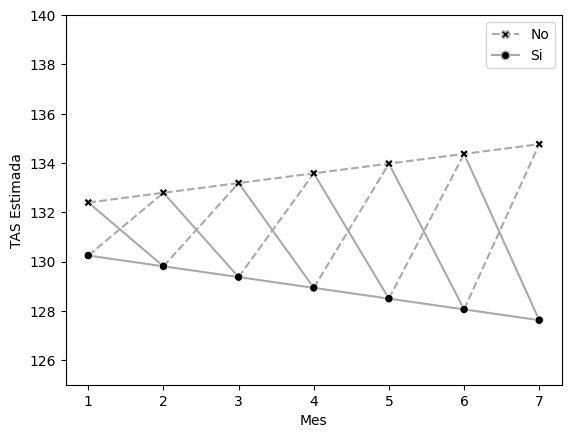

In [314]:
sns.scatterplot(
    data=scatter_df_1,
    x="Mes",
    y="Estimated",
    style=scatter_df_1["Adherencia"].map({0: "No", 1: "Si"}),
    color="black",
    zorder=2,
    markers={"No": "X", "Si": "o"}
)
sns.lineplot(
    data=dashed_lines_df_1,
    y="Estimated",
    x="Mes",
    hue="id",
    linestyle="--",
    palette=["darkgrey"] * dashed_lines_df_1["id"].nunique(),
    zorder=1
)
sns.lineplot(
    data=lines_df_1,
    y="Estimated",
    x="Mes",
    hue="id",
    linestyle="-",
    palette=["darkgrey"] * lines_df_1["id"].nunique(),
    zorder=1
)

plt.ylim(YLIM)
plt.ylabel("TAS Estimada")
plt.legend(handles=handles)

# Modelo 2

In [315]:
formula = ro.Formula("TAS ~ Sexo + Edad + Adherencia_Perfecta + Mes + Mes:Adherencia_Perfecta")
modelo_2 = nlme.lme(formula, random=random_formula, data=tesis, method="ML", corr=nlme.corAR1())

In [316]:
with open("../Tesina/Mio/tables/modelo_2.tex", "w") as f:
    f.write(model_to_latex(modelo_2))

In [322]:
df_2 = pd.DataFrame(
    {
        "Mes": list(range(1, 8)) * 2,
        "Adherencia_Perfecta": [0] * 7 + [1] * 7,
        "id": [0] * 7 + [1] * 7,
    }
)

df_2 = create_sample_df(df_2)
df_2["Estimated"] = get_predictions(modelo_2, df_2)

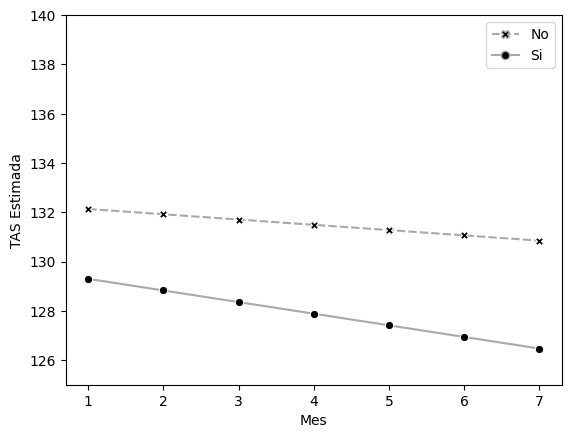

In [342]:
sns.lineplot(
    data=df_2,
    y="Estimated",
    x="Mes",
    hue="id",
    palette=["darkgrey"] * 2,
    style="Adherencia_Perfecta",
    style_order=[1, 0],
    markers={0: "X", 1: "o"},
    markerfacecolor="black",
)
plt.ylim(YLIM)
plt.ylabel("TAS Estimada")
plt.legend(handles=handles)

# Modelo 3

In [343]:
formula = ro.Formula("TAS ~ Sexo + Edad + Adherencia_Total + Mes + Mes:Adherencia_Total")
modelo_3 = nlme.lme(formula, random=random_formula, data=tesis, method="ML", corr=nlme.corAR1())

In [344]:
with open("../Tesina/Mio/tables/modelo_3.tex", "w") as f:
    f.write(model_to_latex(modelo_3))

In [359]:
df_3 = pd.DataFrame(
    {
        "Mes": list(range(1, 8)) * 8,
        "Adherencia_Total": [i/7 for i in range(8) for j in range(7)],
        "id": [i for i in range(8) for j in range(7)],
    }
)

df_3 = create_sample_df(df_3)
df_3["Estimated"] = get_predictions(modelo_3, df_3)

Text(0, 0.5, 'TAS Estimada')

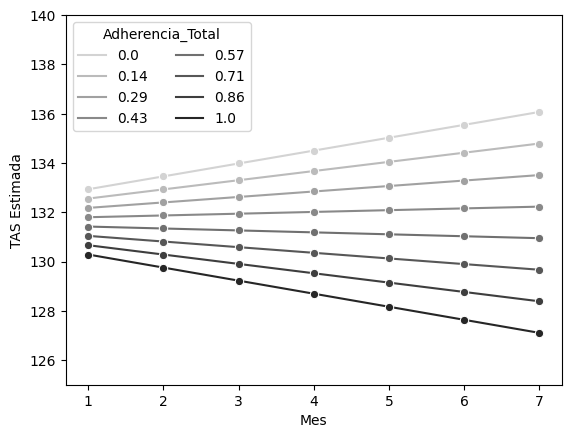

In [366]:
sns.lineplot(
    x=df_3["Mes"],
    y=df_3["Estimated"],
    hue=df_3["Adherencia_Total"].round(2),
    marker="o",
    palette=sorted(sns.color_palette("dark:lightgrey", n_colors=df_3["Adherencia_Total"].nunique()), reverse=True)
)
plt.ylim(YLIM)
plt.legend(ncol=2, title="Adherencia_Total")
plt.ylabel("TAS Estimada")

# Modelo 4

In [367]:
formula = ro.Formula("TAS ~ Sexo + Edad + Adherencia_lag1 + Mes + Mes:Adherencia_lag1")
modelo_4 = nlme.lme(formula, random=random_formula, data=tesis, method="ML", corr=nlme.corAR1())

In [368]:
with open("../Tesina/Mio/tables/modelo_4.tex", "w") as f:
    f.write(model_to_latex(modelo_4))

In [373]:
scatter_df_4 = pd.DataFrame(
    {
        "Mes": list(range(1, 8)) * 2,
        "Adherencia_lag1": [0] * 8 + [1] * 6
    }
)
scatter_df_4 = create_sample_df(scatter_df_4)
scatter_df_4["Estimated"] = get_predictions(modelo_4, scatter_df_4)

dashed_lines_df_4 = pd.DataFrame(
    {
        "Mes": [
            1, 2, 3, 4, 5, 6, 7,
            1, 2,
            2, 3,
            3, 4,
            4, 5,
            5, 6,
            6, 7,
        ],
        "Adherencia_lag1": [
            0, 0, 0, 0, 0, 0, 0,
            1, 0,
            1, 0,
            1, 0,
            1, 0,
            1, 0,
            1, 0,
        ],
        "id": [
            1, 1, 1, 1, 1, 1, 1,
            2, 2,
            3, 3,
            4, 4,
            5, 5,
            6, 6,
            7, 7,
        ]
    }
)

lines_df_4 = dashed_lines_df_4.copy()
lines_df_4["Adherencia_lag1"] = (dashed_lines_df_4["Adherencia_lag1"] - 1).abs()

dashed_lines_df_4 = create_sample_df(dashed_lines_df_4)
dashed_lines_df_4["Estimated"] = get_predictions(modelo_4, dashed_lines_df_4)

lines_df_4 = create_sample_df(lines_df_4)
lines_df_4["Estimated"] = get_predictions(modelo_4, lines_df_4)

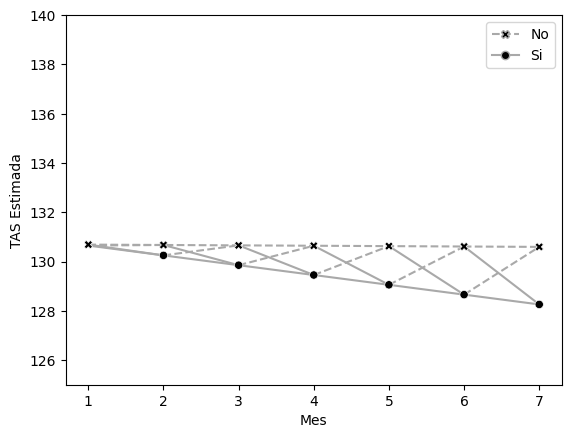

In [375]:
sns.scatterplot(
    data=scatter_df_4,
    x="Mes",
    y="Estimated",
    style=scatter_df_4["Adherencia_lag1"].map({0: "No", 1: "Si"}),
    color="black",
    zorder=2,
    markers={"No": "X", "Si": "o"}
)
sns.lineplot(
    data=dashed_lines_df_4,
    y="Estimated",
    x="Mes",
    hue="id",
    linestyle="--",
    palette=["darkgrey"] * dashed_lines_df_4["id"].nunique(),
    zorder=1
)
sns.lineplot(
    data=lines_df_4,
    y="Estimated",
    x="Mes",
    hue="id",
    linestyle="-",
    palette=["darkgrey"] * lines_df_4["id"].nunique(),
    zorder=1
)

plt.ylim(YLIM)
plt.ylabel("TAS Estimada")
plt.legend(handles=handles)

# Modelo 5

In [376]:
formula = ro.Formula("TAS ~ Sexo + Edad + Adherencia_Acumulada + Mes + Mes:Adherencia_Acumulada")
modelo_5 = nlme.lme(formula, random=random_formula, data=tesis, method="ML", corr=nlme.corAR1())

In [377]:
with open("../Tesina/Mio/tables/modelo_5.tex", "w") as f:
    f.write(model_to_latex(modelo_5))

In [412]:
scatter_df_5 = pd.DataFrame(
    {
        "Mes": [i-1 for i in range(2, 9) for j in range(i)],
        "Adherencia_Acumulada": [j/(i-1) for i in range(2, 9) for j in range(i)]
    }
)
scatter_df_5 = create_sample_df(scatter_df_5)
scatter_df_5["Estimated"] = get_predictions(modelo_5, scatter_df_5)

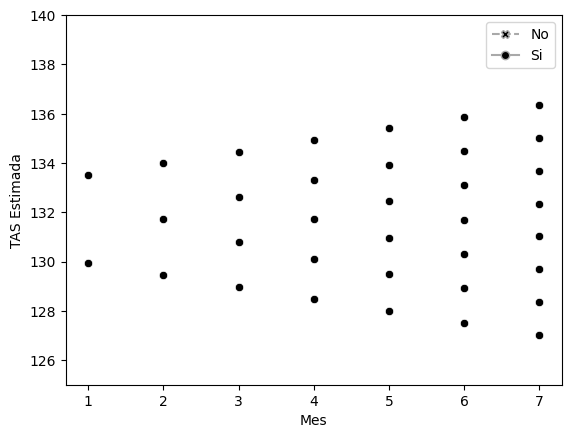

In [415]:
sns.scatterplot(
    data=scatter_df_5,
    x="Mes",
    y="Estimated",
    color="black"
)

plt.ylim(YLIM)
plt.ylabel("TAS Estimada")
plt.legend(handles=handles)

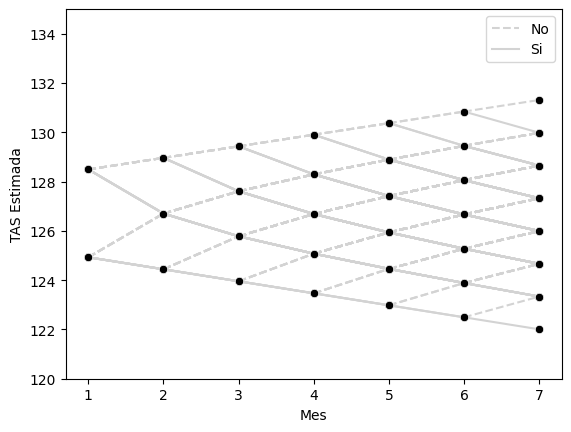

In [27]:
sample_df["Estimated_modelo_5"] = get_predictions(modelo_5, sample_df)

scatter = sns.scatterplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_5"],
    color="black",
    zorder=2
)
for mes in range(8):
    filtered_df = sample_df[
        ((sample_df["Adherencia"] == 1) & (sample_df["Mes"] == mes)) |
        ((sample_df["Adherencia"] == 0) & (sample_df["Mes"] > mes))
    ]
    filtered_df["Mes_lag1"] = filtered_df.groupby("idPaciente")["Mes"].shift(1).fillna(filtered_df["Mes"])
    filtered_df["diff"] = filtered_df["Mes"] - filtered_df["Mes_lag1"]
    ids_to_remove = filtered_df[filtered_df["diff"] > 1]["idPaciente"].unique()
    filtered_df = filtered_df[~filtered_df["idPaciente"].isin(ids_to_remove)]
    filtered_df = filtered_df.groupby("idPaciente").head(2)
    lineplot = sns.lineplot(
        data=filtered_df,
        x="Mes",
        y="Estimated_modelo_5",
        hue="idPaciente",
        palette=["lightgrey"] * filtered_df["idPaciente"].nunique(),
        zorder=1,
        linestyle="--"
    )
    filtered_df = sample_df[
        ((sample_df["Adherencia"] == 0) & (sample_df["Mes"] == mes)) |
        ((sample_df["Adherencia"] == 1) & (sample_df["Mes"] > mes))
    ]
    filtered_df["Mes_lag1"] = filtered_df.groupby("idPaciente")["Mes"].shift(1).fillna(filtered_df["Mes"])
    filtered_df["diff"] = filtered_df["Mes"] - filtered_df["Mes_lag1"]
    ids_to_remove = filtered_df[filtered_df["diff"] > 1]["idPaciente"].unique()
    filtered_df = filtered_df[~filtered_df["idPaciente"].isin(ids_to_remove)]
    filtered_df = filtered_df.groupby("idPaciente").head(2)
    lineplot = sns.lineplot(
        data=filtered_df,
        x="Mes",
        y="Estimated_modelo_5",
        hue="idPaciente",
        palette=["lightgrey"] * filtered_df["idPaciente"].nunique(),
        zorder=1,
        linestyle="-"
    )
plt.ylim(YLIM)
plt.ylabel("TAS Estimada")

plt.legend(handles=handles_5)

# Modelo 6

In [28]:
formula = ro.Formula("TAS ~ Sexo + Edad + Adherencia + Adherencia_Total + Mes + Mes:Adherencia + Mes:Adherencia_Total")
modelo_6 = nlme.lme(formula, random=random_formula, data=tesis, method="ML", corr=nlme.corAR1())

In [29]:
with open("../Tesina/Mio/tables/modelo_6.tex", "w") as f:
    f.write(model_to_latex(modelo_6))

In [30]:
# sample_df["Estimated_modelo_6"] = get_predictions(modelo_6, sample_df)

# sns.lineplot(
#     x=sample_df["Mes"],
#     y=sample_df["Estimated_modelo_6"],
#     hue=sample_df["idPaciente"],
#     marker="o"
# )
# plt.ylim(YLIM)

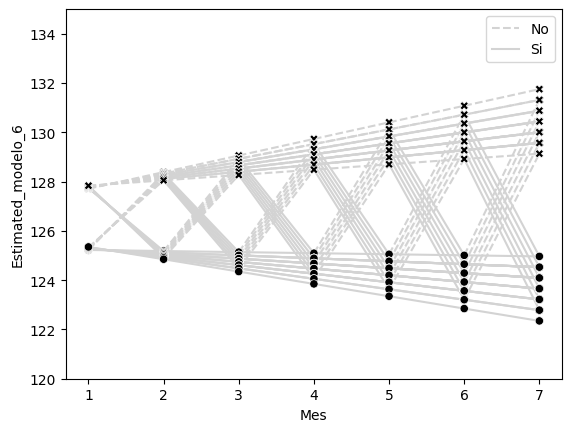

In [35]:
sample_df["Estimated_modelo_6"] = get_predictions(modelo_6, sample_df)

scatter = sns.scatterplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_6"],
    style=sample_df["Adherencia"].map({0: "No", 1: "Si"}),
    markers={"No": "X", "Si": "o"},
    color="black",
    zorder=2,
)
for mes in range(8):
    filtered_df = sample_df[
        ((sample_df["Adherencia"] == 1) & (sample_df["Mes"] == mes)) |
        ((sample_df["Adherencia"] == 0) & (sample_df["Mes"] > mes))
    ]
    filtered_df["Mes_lag1"] = filtered_df.groupby("idPaciente")["Mes"].shift(1).fillna(filtered_df["Mes"])
    filtered_df["diff"] = filtered_df["Mes"] - filtered_df["Mes_lag1"]
    ids_to_remove = filtered_df[filtered_df["diff"] > 1]["idPaciente"].unique()
    filtered_df = filtered_df[~filtered_df["idPaciente"].isin(ids_to_remove)]
    filtered_df = filtered_df.groupby("idPaciente").head(2)
    lineplot = sns.lineplot(
        data=filtered_df,
        x="Mes",
        y="Estimated_modelo_6",
        hue="Adherencia_Total",
        palette=["lightgrey"] * filtered_df["Adherencia_Total"].nunique(),
        zorder=1,
        linestyle="--"
    )
    filtered_df = sample_df[
        ((sample_df["Adherencia"] == 0) & (sample_df["Mes"] == mes)) |
        ((sample_df["Adherencia"] == 1) & (sample_df["Mes"] > mes))
    ]
    filtered_df["Mes_lag1"] = filtered_df.groupby("idPaciente")["Mes"].shift(1).fillna(filtered_df["Mes"])
    filtered_df["diff"] = filtered_df["Mes"] - filtered_df["Mes_lag1"]
    ids_to_remove = filtered_df[filtered_df["diff"] > 1]["idPaciente"].unique()
    filtered_df = filtered_df[~filtered_df["idPaciente"].isin(ids_to_remove)]
    filtered_df = filtered_df.groupby("idPaciente").head(2)
    lineplot = sns.lineplot(
        data=filtered_df,
        x="Mes",
        y="Estimated_modelo_6",
        hue="Adherencia_Total",
        palette=["lightgrey"] * filtered_df["Adherencia_Total"].nunique(),
        zorder=1,
        linestyle="-"
    )
plt.ylim(YLIM)

plt.legend(handles=handles_5)